# Vanilla model

In [1]:
#!/usr/bin/env python
# coding: utf-8
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.nn.functional as F  # All functions that don't have any parameters
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, matthews_corrcoef

## Load data

In [13]:
data_list = []
target_list = []

import glob

for fp in glob.glob("../hackathon_data_scripts/data/train/*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]

    data_list.append(data)
    target_list.append(targets)
# print(data_list)
X_test = np.load('../hackathon_data_scripts/data/final_test/P5_input.npz')["arr_0"]
y_test = np.load('../hackathon_data_scripts/data/final_test/P5_labels.npz')["arr_0"]

# Note:
# Choose your own training and val set based on data_list and target_list
# Here using the last partition as val set

X_train = np.concatenate(data_list[:-1])
y_train = np.concatenate(target_list[:-1])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples, nx, ny)

X_val = np.concatenate(data_list[-1:])
y_val = np.concatenate(target_list[-1:])
nsamples, nx, ny = X_val.shape
print("val set shape:", nsamples, nx, ny)

nsamples, nx, ny = X_test.shape
print("Test set shape:", nsamples, nx, ny)

p_neg = len(y_train[y_train == 1]) / len(y_train) * 100
print("Percent positive samples in train:", p_neg)

p_pos = len(y_val[y_val == 1]) / len(y_val) * 100
print("Percent positive samples in val:", p_pos)


# make the data set into one dataset that can go into dataloader
train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i]), y_train[i]])

val_ds = []
for i in range(len(X_val)):
    val_ds.append([np.transpose(X_val[i]), y_val[i]])

test_ds = []
for i in range(len(X_test)):
    test_ds.append([np.transpose(X_test[i]), y_test[i]])

bat_size = 64
print("\nNOTE:\nSetting batch-size to", bat_size)
train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds, batch_size=bat_size, shuffle=True)
test_ldr = torch.utils.data.DataLoader(test_ds, batch_size=bat_size, shuffle=True)


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device (CPU/GPU):", device)
# device = torch.device("cpu")

Training set shape: 4180 420 54
val set shape: 1526 420 54
Test set shape: 1207 420 54
Percent positive samples in train: 25.0
Percent positive samples in val: 24.901703800786372

NOTE:
Setting batch-size to 64
Using device (CPU/GPU): cpu


## Define network

Changes in network (compared to example notebook)  
- drop out between convolutional layers (0.3)
- add lstm
- adapt dense layer to output of lstm
- sigmoid activation function of dense layer output so we get classes as output (or change loss to BCEWithLogitsLoss?)
- adam optimizer with weight decay instead of SGD 
- learning rate to 0.001 and more epochs
- early stopping after 5 iterations without improved validation loss
- weighted loss

In [4]:
# Hyperparameters
# input_size = 420
_, input_size, n_features = X_train.shape
n_local_feat = 27
n_global_feat = n_features - n_local_feat
num_classes = 1
# learning_rate = 0.01
learning_rate = 0.001

loss_weight = sum(y_train) / len(y_train)
print("loss weight", loss_weight)

class Net(nn.Module):
    def __init__(self,  num_classes):
        super(Net, self).__init__()   
        self.bn0 = nn.BatchNorm1d(n_local_feat)
        self.conv1 = nn.Conv1d(in_channels=n_local_feat, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv1_bn = nn.BatchNorm1d(100)
        
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv2_bn = nn.BatchNorm1d(100)
        
        ######## code from master thesis 
        self.rnn = nn.LSTM(input_size=100,hidden_size=26,num_layers=3, dropout=0.5, batch_first=True, bidirectional = True)
        self.drop = nn.Dropout(p = 0.5) # Dunno if dropout should be even higher?? - Christian
        self.fc1 = nn.Linear(26*2 + n_global_feat, 26*2 + n_global_feat)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        ########
        
        # since we add new features in this step, we have to use batch normalization again
        self.bn1 = nn.BatchNorm1d(26*2 + n_global_feat)
        # if we pipe the global terms innto the fc, we should have more than just 1
        self.fc2 = nn.Linear(26*2 + n_global_feat, num_classes)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        local_features = x[:, :27, :]
        # global features are the same for the whole sequence -> take first value
        global_features = x[:, 27:, 0]

        ######## code from master thesis
        x = self.bn0(local_features)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)
        x = self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)
        x = self.drop(x)
        x = x.transpose_(2, 1)
        x, (h, c) = self.rnn(x)
        # concatenate bidirectional output of last layer
        cat = torch.cat((h[-2, :, :], h[-1, :, :]), dim=1)
        # add global features
        x = torch.cat((cat, global_features), dim=1)
        x = self.drop(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = torch.sigmoid(self.fc2(x))
        ########
        
        return x
    
# Initialize network
net = Net(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.BCELoss(reduction='none')  # for weighted loss
# optimizer = optim.SGD(net.parameters(), lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate,
    weight_decay=0.0005,
    amsgrad=True
)

loss weight 0.25


## Training

In [5]:
num_epochs = 100

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
losses = []
val_losses = []

# for early stopping
no_epoch_improve = 0
min_val_loss = np.Inf

for epoch in range(num_epochs):
    cur_loss = 0
    val_loss = 0

    net.train()
    train_preds, train_preds_auc, train_targs = [], [], []
    for batch_idx, (data, target) in enumerate(train_ldr):
        X_batch = data.float().detach().requires_grad_(True)
        target_batch = torch.tensor(np.array(target), dtype=torch.float).unsqueeze(1)

        optimizer.zero_grad()
        output = net(X_batch)

        # calculate weighted loss
        intermediate_loss = criterion(output, target_batch)
        weights = torch.FloatTensor(abs(target_batch - loss_weight))
        batch_loss = torch.mean(weights * intermediate_loss)
        # batch_loss = criterion(output, target_batch)
        
        batch_loss.backward()
        optimizer.step()

        preds = np.round(output.detach().cpu())
        preds_auc = output.detach().cpu()
        train_targs += list(np.array(target_batch.cpu()))
        train_preds += list(preds.data.numpy().flatten())
        train_preds_auc += list(preds_auc.data.numpy().flatten())
        cur_loss += batch_loss.detach()

    losses.append(cur_loss / len(train_ldr.dataset))

    net.eval()
    ### Evaluate validation
    val_preds, val_preds_auc, val_targs = [], [], []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_ldr):  ###
            x_batch_val = data.float().detach()
            y_batch_val = target.float().detach().unsqueeze(1)

            output = net(x_batch_val)

            # calculate weighted loss
            intermediate_loss = criterion(output, y_batch_val)
            weights = torch.FloatTensor(abs(y_batch_val - loss_weight))
            val_batch_loss = torch.mean(weights * intermediate_loss)
            # val_batch_loss = criterion(output, y_batch_val)

            preds = np.round(output.detach())
            val_preds += list(preds.data.numpy().flatten())
            preds_auc = output.detach()
            val_preds_auc += list(preds_auc.data.numpy().flatten())
            val_targs += list(np.array(y_batch_val))
            val_loss += val_batch_loss.detach()

        val_losses.append(val_loss / len(val_ldr.dataset))
        print("\nEpoch:", epoch + 1)

        train_acc_cur = accuracy_score(train_targs, train_preds)
        valid_acc_cur = accuracy_score(val_targs, val_preds)

        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)


        print(
            "Training loss:",
            losses[-1].item(),
            "Validation loss:",
            val_losses[-1].item(),
            end="\n",
        )
        print(
            "MCC Train:",
            matthews_corrcoef(train_targs, train_preds),
            "MCC val:",
            matthews_corrcoef(val_targs, val_preds),
        )
        
    # Early stopping: no improvement in validation loss in 10 consecutive epochs
    if (val_loss / len(X_val)).item() < min_val_loss:
        no_epoch_improve = 0
        min_val_loss = (val_loss / len(X_val))
        torch.save(net, 'early_stopping_model.pt')
        best_epoch = epoch
    else:
        no_epoch_improve +=1
    if no_epoch_improve == 10:
        print("Early stopping\n")
        break



Epoch: 1
Training loss: 0.004943773616105318 Validation loss: 0.004061962943524122
MCC Train: 0.021229381566543047 MCC val: 0.05623804172297981

Epoch: 2
Training loss: 0.00468738516792655 Validation loss: 0.004101194441318512
MCC Train: 0.009396707744696838 MCC val: 0.05804104169456137

Epoch: 3
Training loss: 0.004564255941659212 Validation loss: 0.004029028583317995
MCC Train: 0.011602339210567534 MCC val: 0.07900557365508402

Epoch: 4
Training loss: 0.004387652035802603 Validation loss: 0.003955635242164135
MCC Train: 0.04061570568181063 MCC val: 0.19870562700745306

Epoch: 5
Training loss: 0.004239898175001144 Validation loss: 0.003944305703043938
MCC Train: 0.07044581389131462 MCC val: 0.1747191095617425

Epoch: 6
Training loss: 0.004139704629778862 Validation loss: 0.003884021658450365
MCC Train: 0.09034599508987996 MCC val: 0.18789453727380134

Epoch: 7
Training loss: 0.004152372013777494 Validation loss: 0.003838048316538334
MCC Train: 0.11054991347567297 MCC val: 0.203841479

## Performance evaluation

(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Acc'))

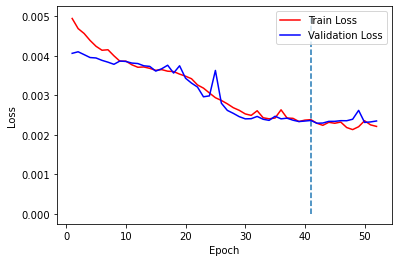

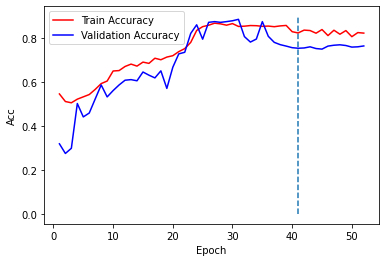

In [8]:
# Plots of training epochs
epoch = np.arange(1, len(train_acc) + 1)
plt.figure()
plt.plot(epoch, losses, "r", epoch, val_losses, "b")
plt.legend(["Train Loss", "Validation Loss"])
plt.vlines(best_epoch, ymin=0, ymax=0.005, linestyles='dashed')
plt.xlabel("Epoch"), plt.ylabel("Loss")

epoch = np.arange(1, len(train_acc) + 1)
plt.figure()
plt.plot(epoch, train_acc, "r", epoch, valid_acc, "b")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.vlines(best_epoch, ymin=0, ymax=0.9, linestyles='dashed')
plt.xlabel("Epoch"), plt.ylabel("Acc")

In [23]:
# Performance evaluation metrics of final model

final_model = torch.load('early_stopping_model.pt')
final_model.train()
train_preds, train_preds_auc, train_targs = [], [], []
for batch_idx, (data, target) in enumerate(train_ldr):
    X_batch = data.float().detach().requires_grad_(True)
    target_batch = torch.tensor(np.array(target), dtype=torch.float).unsqueeze(1)
    
    output = final_model(X_batch)
    preds = np.round(output.detach().cpu())
    preds_auc = output.detach().cpu()
    train_targs += list(np.array(target_batch.cpu()))
    train_preds += list(preds.data.numpy().flatten())
    train_preds_auc += list(preds_auc.data.numpy().flatten())

final_model.eval()
val_preds, val_preds_auc, val_targs = [], [], []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(val_ldr):  ###
        x_batch_val = data.float().detach()
        y_batch_val = target.float().detach().unsqueeze(1)

        output = final_model(x_batch_val)

        preds = np.round(output.detach())
        val_preds += list(preds.data.numpy().flatten())
        preds_auc = output.detach()
        val_preds_auc += list(preds_auc.data.numpy().flatten())
        val_targs += list(np.array(y_batch_val))
        val_loss += val_batch_loss.detach()

print("MCC Train:", matthews_corrcoef(train_targs, train_preds))
print("MCC Test:", matthews_corrcoef(val_targs, val_preds))

prec_val = metrics.precision_score(val_targs, val_preds)
rec_val = metrics.recall_score(val_targs, val_preds)
f1_val = 2 * ((prec_val * rec_val) / (prec_val + rec_val))

print("Precision Test:", prec_val)
print("Recall Test:", rec_val)
print("F1 Test:", f1_val)

print("Confusion matrix train:", confusion_matrix(train_targs, train_preds), sep="\n")
print("Confusion matrix test:", confusion_matrix(val_targs, val_preds), sep="\n")

MCC Train: 0.6064183130850456
MCC Test: 0.5272277298893456
Precision Test: 0.5098335854765507
Recall Test: 0.8868421052631579
F1 Test: 0.6474543707973103
Confusion matrix train:
[[2754  381]
 [ 262  783]]
Confusion matrix test:
[[822 324]
 [ 43 337]]


## Model evaluation on the last partition (Test set)

In [24]:
final_model.eval()
test_preds, test_preds_auc, test_targs = [], [], []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_ldr):  ###
        x_batch_val = data.float().detach()
        y_batch_val = target.float().detach().unsqueeze(1)

        output = final_model(x_batch_val)

        preds = np.round(output.detach())
        test_preds += list(preds.data.numpy().flatten())
        preds_auc = output.detach()
        test_preds_auc += list(preds_auc.data.numpy().flatten())
        test_targs += list(np.array(y_batch_val))

print("MCC Test:", matthews_corrcoef(test_targs, test_preds))

prec_test = metrics.precision_score(test_targs, test_preds)
rec_test = metrics.recall_score(test_targs, test_preds)
f1_test = 2 * ((prec_test * rec_test) / (prec_test + rec_test))

print("Precision Test:", prec_test)
print("Recall Test:", rec_test)
print("F1 Test:", f1_test)

print("Confusion matrix test:", confusion_matrix(test_targs, test_preds), sep="\n")

MCC Test: 0.45220634850364644
Precision Test: 0.46828358208955223
Recall Test: 0.8338870431893688
F1 Test: 0.5997610513739546
Confusion matrix test:
[[621 285]
 [ 50 251]]


In [25]:
def plot_roc(targets, predictions):
    # ROC
    fpr, tpr, threshold = metrics.roc_curve(targets, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    # plot ROC
    plt.figure()
    plt.title("Receiver Operating Characteristic")
    plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    # plt.show()

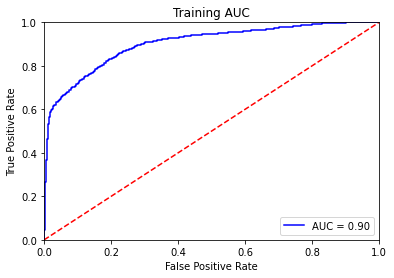

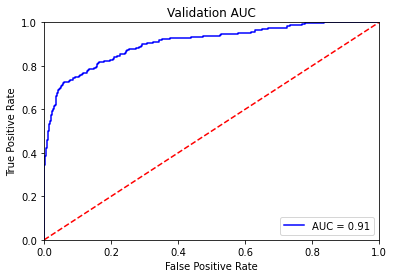

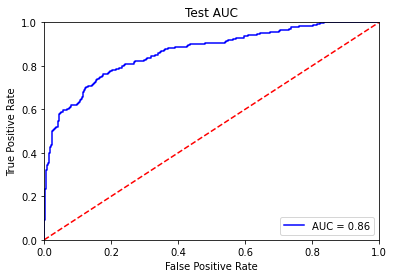

In [26]:
plot_roc(train_targs, train_preds_auc)
plt.title("Training AUC")
plot_roc(val_targs, val_preds_auc)
plt.title("Validation AUC")
plot_roc(test_targs, test_preds_auc)
plt.title("Test AUC")
plt.show()

# Helpful scripts

# Show dataset as copied dataframes with named features
The dataset is a 3D numpy array, of dimensions n_complexes x features x positions. This makes viewing the features for individual complexes or samples challenging. Below is a function which copies the entire dataset, and converts it into a list of DataFrames with named indices and columns, in order to make understanding the data easier.

NB: This list of dataframes are only copies, and will not be passable into the neural network architecture.

In [8]:
pd.read_csv("../hackathon_data_scripts/data/example.csv")

,A,C,D,E,F,G,H,I,K,L,...,global_tcr_fa_rep,global_tcr_fa_sol,global_tcr_p_aa_pp,global_pmhc_total_score,global_pmhc_fa_atr,global_pmhc_fa_dun,global_pmhc_fa_elec,global_pmhc_fa_rep,global_pmhc_fa_sol,global_pmhc_p_aa_pp
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,681.926,-40.471,2.401,-555.661,246.945,-359.301,2.25,733.179,-39.727,0.481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000


In [9]:
def copy_as_dataframes(dataset_X):
    """
    Returns list of DataFrames with named features from dataset_X,
    using example CSV file
    """
    df_raw = pd.read_csv("../hackathon_data_scripts/data/example.csv")
    return [pd.DataFrame(arr, columns=df_raw.columns) for arr in dataset_X]


named_dataframes = copy_as_dataframes(X_train)
print(
    "Showing first complex as dataframe. Columns are positions and indices are calculated features"
)
named_dataframes[0]

Showing first complex as dataframe. Columns are positions and indices are calculated features


,A,C,D,E,F,G,H,I,K,L,...,global_tcr_fa_rep,global_tcr_fa_sol,global_tcr_p_aa_pp,global_pmhc_total_score,global_pmhc_fa_atr,global_pmhc_fa_dun,global_pmhc_fa_elec,global_pmhc_fa_rep,global_pmhc_fa_sol,global_pmhc_p_aa_pp
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,656.289,-47.814,1.699,-571.57,229.289,-359.096,2.145,727.371,-40.566,0.554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000
417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000
418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000


# View complex MHC, peptide and TCR alpha/beta sequences
You may want to view the one-hot encoded sequences as sequences in single-letter amino-acid format. The below function will return the TCR, peptide and MHC sequences for the dataset as 3 lists.

In [10]:
def oneHot(residue):
    """
    Converts string sequence to one-hot encoding
    Example usage:
    seq = "GSHSMRY"
    oneHot(seq)
    """

    mapping = dict(zip("ACDEFGHIKLMNPQRSTVWY", range(20)))
    if residue in "ACDEFGHIKLMNPQRSTVWY":
        return np.eye(20)[mapping[residue]]
    else:
        return np.zeros(20)


def reverseOneHot(encoding):
    """
    Converts one-hot encoded array back to string sequence
    """
    mapping = dict(zip(range(20), "ACDEFGHIKLMNPQRSTVWY"))
    seq = ""
    for i in range(len(encoding)):
        if np.max(encoding[i]) > 0:
            seq += mapping[np.argmax(encoding[i])]
    return seq


def extract_sequences(dataset_X):
    """
    Return DataFrame with MHC, peptide and TCR a/b sequences from
    one-hot encoded complex sequences in dataset X
    """
    mhc_sequences = [reverseOneHot(arr[0:179, 0:20]) for arr in dataset_X]
    pep_sequences = [reverseOneHot(arr[179:190, 0:20]) for arr in dataset_X]
    tcr_sequences = [reverseOneHot(arr[192:, 0:20]) for arr in dataset_X]
    df_sequences = pd.DataFrame(
        {"MHC": mhc_sequences, "peptide": pep_sequences, "tcr": tcr_sequences}
    )
    return df_sequences

In [11]:
complex_sequences = extract_sequences(X_val)
print("Showing MHC, peptide and TCR alpha/beta sequences for each complex")
complex_sequences

Showing MHC, peptide and TCR alpha/beta sequences for each complex


,MHC,peptide,tcr
0,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,EQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVV...
1,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,EQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVV...
2,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,QQVKQNSPSLSVQEGRISILNCDYTNSMFDYFLWYKKYPAEGPTFL...
3,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,EQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVV...
4,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GILGFVFTL,EQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVV...
...,...,...,...
1521,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,FLYALALLL,QSPQSMFIQEGEDVSMNCTSSSIFNTWLWYKQEPGEGPVLLIALYK...
1522,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,LLFGYPVYV,PQALSIQEGENATMNCSYKTSINNLQWYRQNSGRGLVHLILIRSNE...
1523,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,GLCTLVAML,EQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVV...
1524,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,FLYALALLL,QQVKQNSPSLSVQEGRISILNCDYTNSMFDYFLWYKKYPAEGPTFL...
